In [2]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [4]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 24

matplotlib.rc('text', usetex=True)

In [5]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K11'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [6]:
redshift_estimator_name = 'hgboost'
save_tag_model = f''
fn_boost_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_boost_labeled = utils.load_table(fn_boost_labeled)
print(f"N = {len(tab_boost_labeled)}")
print(tab_boost_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err')>


In [5]:
# redshift_estimator_name = 'kNN'
# save_tag_model = f'_K11_prev_hgboost'
# fn_boost_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
# tab_boost_labeled = utils.load_table(fn_boost_labeled)
# print(f"N = {len(tab_boost_labeled)}")
# print(tab_boost_labeled.columns)

In [6]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
# N_tot=N_gaia because the numbers go up to all the ones in the clean catalog
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [7]:
z_sdss_valid = tab_spz_labeled['z_sdss'][i_valid]
z_spzraw_valid = tab_spz_labeled['redshift_spz_raw'][i_valid]
z_gaia_valid = tab_spz_labeled['redshift_qsoc'][i_valid]
z_boostraw_valid = tab_boost_labeled['redshift_spz_raw'][i_valid]

In [44]:
dz_spzraw_gaia = (z_spzraw_valid - z_gaia_valid)/(1+z_gaia_valid)
dz_spzraw_sdss = (z_spzraw_valid - z_sdss_valid)/(1+z_sdss_valid)
dz_gaia_sdss = (z_gaia_valid - z_sdss_valid)/(1+z_sdss_valid)
dz_boostraw_sdss = (z_boostraw_valid - z_sdss_valid)/(1+z_sdss_valid)
dz_boostraw_gaia = (z_boostraw_valid - z_gaia_valid)/(1+z_gaia_valid)
dz_boostraw_spzraw = (z_boostraw_valid - z_spzraw_valid)/(1+z_spzraw_valid)

In [9]:
z_bins = np.linspace(0,np.max(z_gaia_valid),100)

Text(0, 0.5, '$z_\\mathrm{\\textit{Gaia}}$, Gaia redshift')

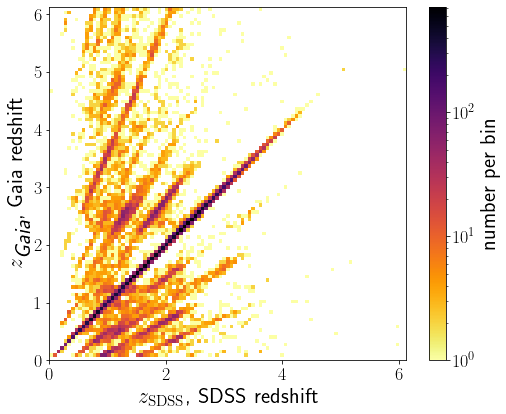

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_valid, z_gaia_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

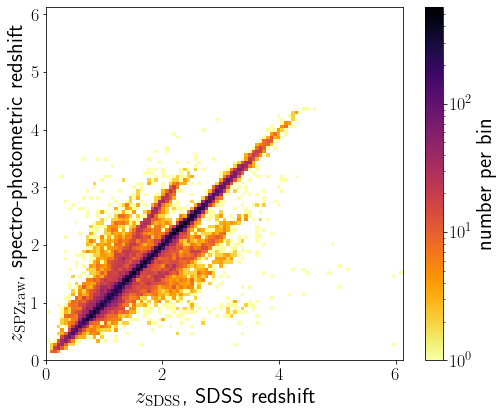

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_valid, z_spzraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

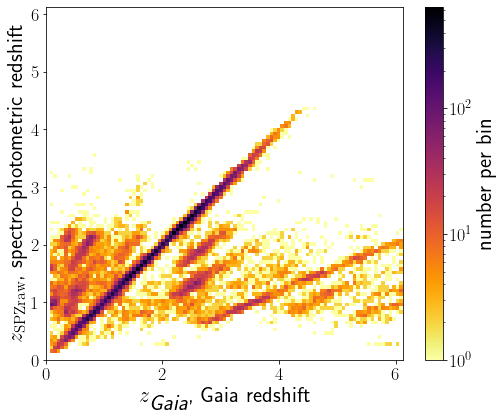

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

Text(0, 0.5, '$z_\\mathrm{SPZboostraw}$, spectro-photometric redshift')

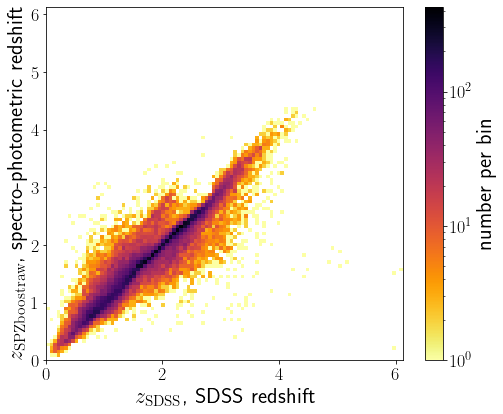

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_valid, z_boostraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{SPZboostraw}$, spectro-photometric redshift')

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

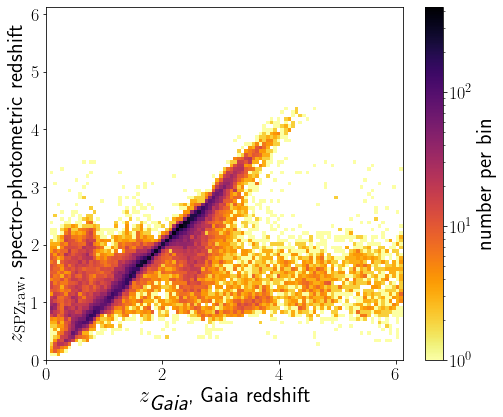

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_boostraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              ) 
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

Text(0, 0.5, '$z_\\mathrm{SPZboost}$, Gaia redshift')

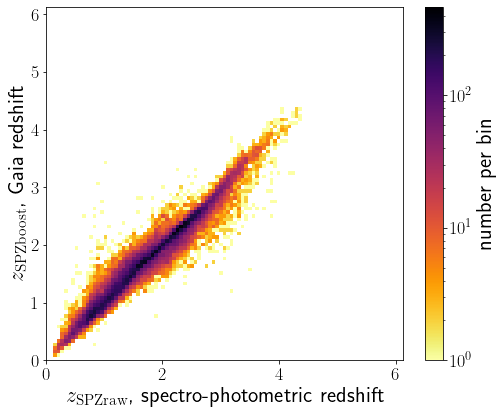

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_spzraw_valid, z_boostraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              ) 
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')
plt.ylabel(r'$z_\mathrm{SPZboost}$, Gaia redshift')

0.6464561365365801


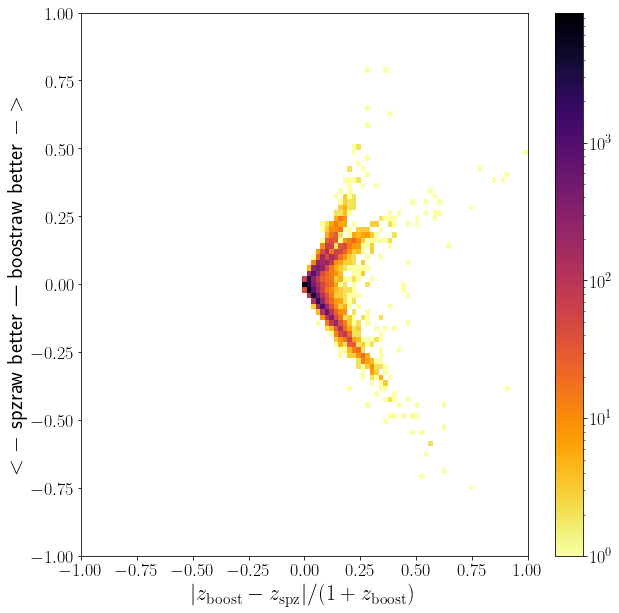

In [54]:
#dz_bins = np.linspace(-0.2, 0.2, 50)
dz_bins = np.linspace(-1, 1, 100)
plt.figure(figsize=(10,10))
plt.hist2d(np.abs(dz_boostraw_spzraw), np.abs(dz_spzraw_sdss)-np.abs(dz_boostraw_sdss), bins=dz_bins, cmin=1, cmap='inferno_r',
           norm=matplotlib.colors.LogNorm(),
           )
plt.colorbar()

plt.xlabel(r'$|z_\mathrm{boost}-z_\mathrm{spz}|/(1+z_\mathrm{boost})$')
plt.ylabel(r'$<-$ spzraw better | boostraw better $->$')
# plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
# plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')

i_spzraw_gaia_agree = (np.abs(dz_spzraw_gaia) < 0.1)
i_gaia_sdss_agree = (np.abs(dz_gaia_sdss) < 0.1)
print(np.sum(i_spzraw_gaia_agree & i_gaia_sdss_agree)/len(i_gaia_sdss_agree))

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

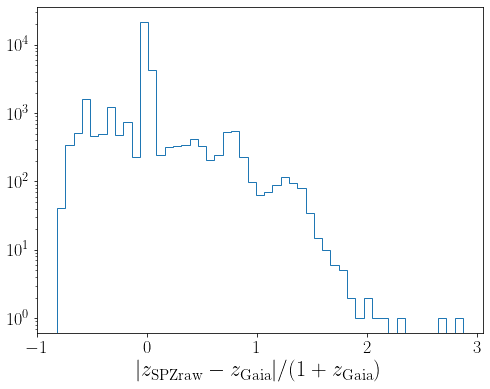

In [15]:
dz_bins = np.linspace(np.min(dz_spzraw_gaia), np.max(dz_spzraw_gaia), 50)

plt.figure(figsize=(8,6))
plt.hist(dz_spzraw_gaia, bins=dz_bins, histtype='step')
plt.yscale('log')

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

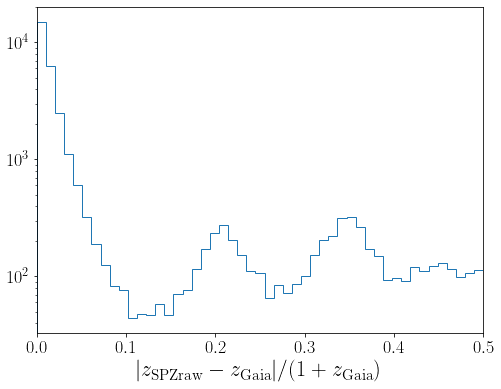

In [117]:
dz_bins = np.linspace(0, 0.5, 50)

plt.figure(figsize=(8,6))
plt.hist(np.abs(dz_spzraw_gaia), bins=dz_bins, histtype='step')
plt.yscale('log')

plt.xlim(0, 0.5)
plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

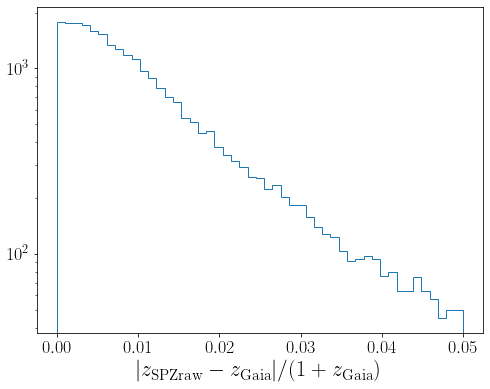

In [122]:
dz_bins = np.linspace(0, 0.05, 50)

plt.figure(figsize=(8,6))
plt.hist(np.abs(dz_spzraw_gaia), bins=dz_bins, histtype='step')
plt.yscale('log')

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

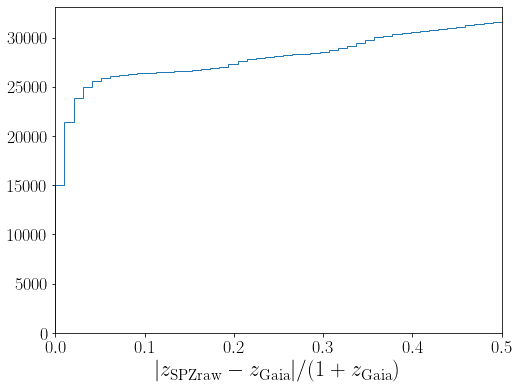

In [119]:
dz_bins = np.linspace(0, 0.5, 50)

plt.figure(figsize=(8,6))
plt.hist(np.abs(dz_spzraw_gaia), bins=dz_bins, histtype='step', cumulative=True)
#plt.yscale('log')

plt.xlim(0, 0.5)
plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

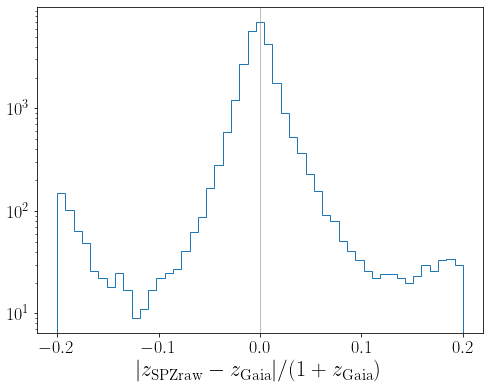

In [16]:
dz_bins = np.linspace(-0.2, 0.2, 50)

plt.figure(figsize=(8,6))
plt.hist(dz_spzraw_gaia, bins=dz_bins, histtype='step')
plt.yscale('log')

plt.axvline(0.0, color='grey', lw=0.5)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

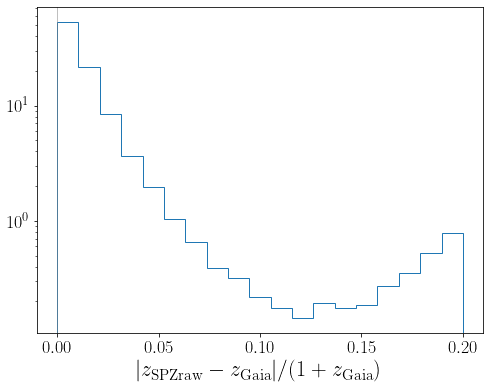

In [120]:
dz_bins = np.linspace(0, 0.2, 20)

plt.figure(figsize=(8,6))
plt.hist(np.abs(dz_spzraw_gaia), bins=dz_bins, histtype='step', density=True)
plt.yscale('log')

plt.axvline(0.0, color='grey', lw=0.5)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

In [112]:
i_near = np.abs(dz_spzraw_gaia) < 0.15
print(np.percentile(np.abs(dz_spzraw_gaia[i_near]), 16))
print(np.percentile(np.abs(dz_spzraw_gaia[i_near]), 95.4))
print(np.percentile(np.abs(dz_spzraw_gaia[i_near]), 99.7))

0.0024437162249456895
0.046934803698199336
0.13469704858913276


Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

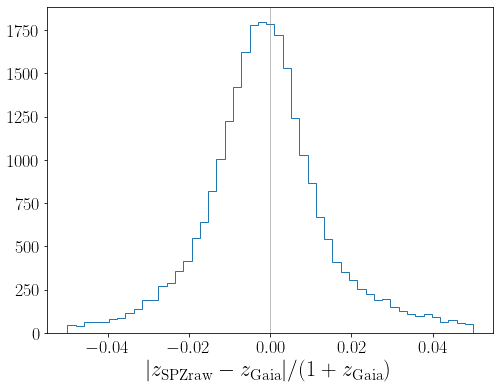

In [17]:
dz_bins = np.linspace(-0.05, 0.05, 50)

plt.figure(figsize=(8,6))
plt.hist(dz_spzraw_gaia, bins=dz_bins, histtype='step')
#plt.yscale('log')

plt.axvline(0.0, color='grey', lw=0.5)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0, 0.5, '$|z_\\mathrm{Gaia}-z_\\mathrm{SDSS}|/(1+z_\\mathrm{SDSS})$')

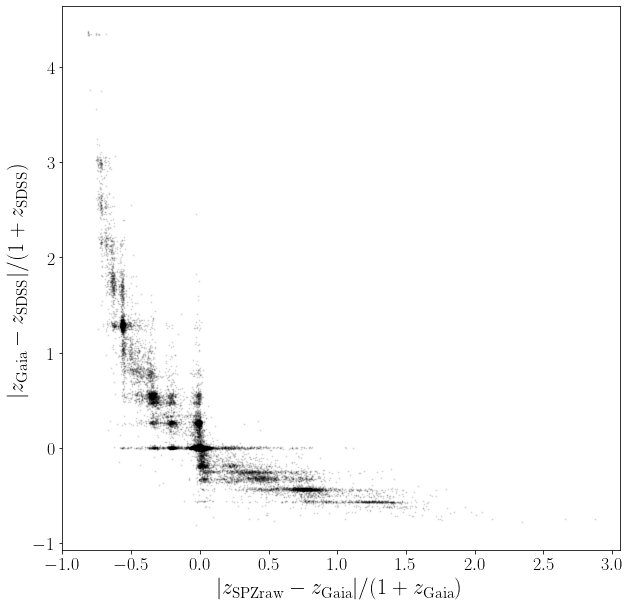

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(dz_spzraw_gaia, dz_gaia_sdss, color='k', s=1, alpha=0.1)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')


0.6464561365365801


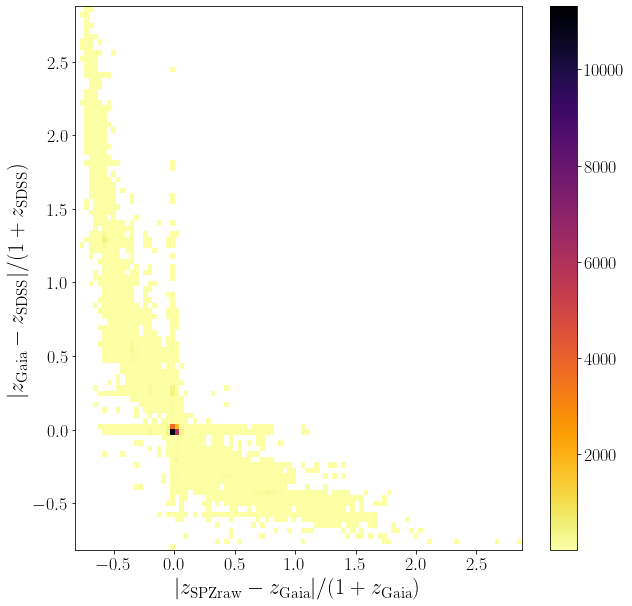

In [19]:
#dz_bins = np.linspace(-0.2, 0.2, 50)
dz_bins = np.linspace(np.min(dz_spzraw_gaia), np.max(dz_spzraw_gaia), 100)
plt.figure(figsize=(10,10))
plt.hist2d(dz_spzraw_gaia, dz_gaia_sdss, bins=dz_bins, cmin=1, cmap='inferno_r')
plt.colorbar()

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')

i_spzraw_gaia_agree = (np.abs(dz_spzraw_gaia) < 0.1)
i_gaia_sdss_agree = (np.abs(dz_gaia_sdss) < 0.1)
print(np.sum(i_spzraw_gaia_agree & i_gaia_sdss_agree)/len(i_gaia_sdss_agree))

0.6464561365365801


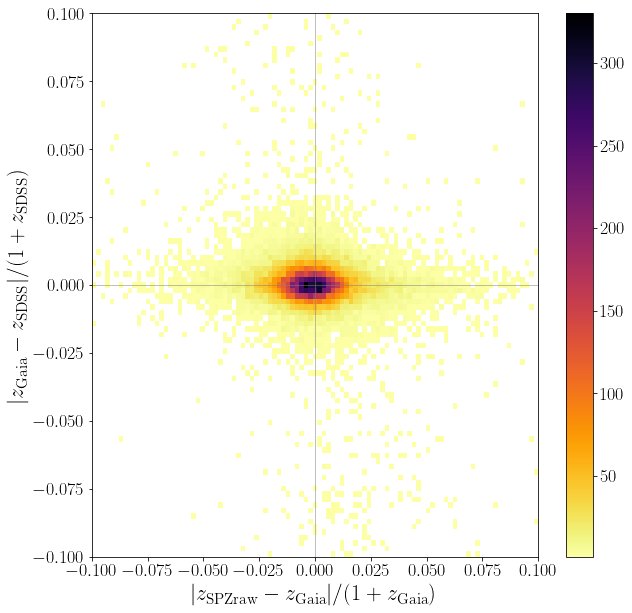

In [20]:
dz_bins = np.linspace(-0.1, 0.1, 100)
#dz_bins = np.linspace(np.min(dz_spzraw_gaia), np.max(dz_spzraw_gaia), 100)
plt.figure(figsize=(10,10))
plt.hist2d(dz_spzraw_gaia, dz_gaia_sdss, bins=dz_bins, cmin=1, cmap='inferno_r')
plt.colorbar()

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')

plt.axvline(0.0, color='grey', lw=0.5)
plt.axhline(0.0, color='grey', lw=0.5)

i_spzraw_gaia_agree = (np.abs(dz_spzraw_gaia) < 0.1)
i_gaia_sdss_agree = (np.abs(dz_gaia_sdss) < 0.1)
print(np.sum(i_spzraw_gaia_agree & i_gaia_sdss_agree)/len(i_gaia_sdss_agree))

In [21]:
from scipy.stats import norm

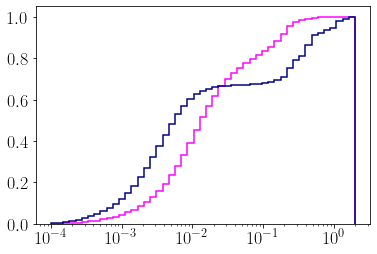

In [22]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)
# cdf_dz_spzraw, _ = np.histogram(dz_spzraw_sdss, bins=dz_bins_log, normed=True)
# cdf_dz_gaia, _ = np.histogram(dz_gaia_sdss, bins=dz_bins_log, normed=True)
# plt.plot(cdf_dz_spzraw)
# plt.plot(cdf_dz_gaia)
lw=1.5
# plt.xscale('log')
h_spzraw, _, _ = plt.hist(abs(dz_spzraw_sdss), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='magenta', label=r'$z=z_\mathrm{SPZ}$')
h_gaia, _, _ = plt.hist(abs(dz_gaia_sdss), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.xscale('log')

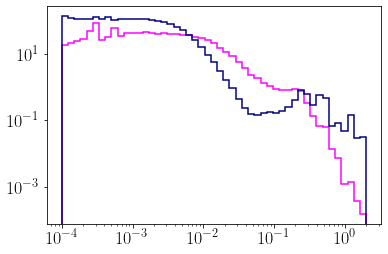

In [101]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)
# cdf_dz_spzraw, _ = np.histogram(dz_spzraw_sdss, bins=dz_bins_log, normed=True)
# cdf_dz_gaia, _ = np.histogram(dz_gaia_sdss, bins=dz_bins_log, normed=True)
# plt.plot(cdf_dz_spzraw)
# plt.plot(cdf_dz_gaia)
lw=1.5
# plt.xscale('log')
h_spzraw, _, _ = plt.hist(abs(dz_spzraw_sdss), bins=dz_bins_log, 
         histtype='step', cumulative=False, density=True, lw=lw,
         color='magenta', label=r'$z=z_\mathrm{SPZ}$')
h_gaia, _, _ = plt.hist(abs(dz_gaia_sdss), bins=dz_bins_log, 
         histtype='step', cumulative=False, density=True, lw=lw,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.xscale('log')
plt.yscale('log')

In [23]:
dz_bins_log_avg = 10**(0.5*(np.log10(dz_bins_log[:-1]) + np.log10(dz_bins_log[1:])))
i_dz = (dz_bins_log_avg >= 1e-3) & (dz_bins_log_avg < 1e-1)
diffs = np.abs(h_spzraw[i_dz] - h_gaia[i_dz])
i_min = np.argmin(diffs)
dz_x = dz_bins_log_avg[i_dz][i_min]
print(dz_x, h_gaia[i_dz][i_min])

0.02593243899527689 0.6637160751565763


In [24]:
z_spzx_valid = z_spzraw_valid.copy()
i_usegaia_x = np.abs(dz_spzraw_gaia) < dz_x
print("Number of SPZ's we'll switch out for Gaia:", np.sum(i_usegaia_x), "out of", len(i_usegaia_x))
print(np.sum(i_usegaia_x)/len(i_usegaia_x))
z_spzx_valid[i_usegaia_x] = z_gaia_valid[i_usegaia_x]
dz_spzx_sdss = (z_spzx_valid - z_sdss_valid)/(1+z_sdss_valid)

Number of SPZ's we'll switch out for Gaia: 22979 out of 36796
0.6244972279595609


In [25]:
z_spzhi_valid = z_spzraw_valid.copy()
dz_hi = 0.1
i_usegaia_hi = np.abs(dz_spzraw_gaia) < dz_hi
print("Number of SPZ's we'll switch out for Gaia:", np.sum(i_usegaia_hi), "out of", len(i_usegaia_hi))
print(np.sum(i_usegaia_hi)/len(i_usegaia_hi))
z_spzhi_valid[i_usegaia_hi] = z_gaia_valid[i_usegaia_hi]
dz_spzhi_sdss = (z_spzhi_valid - z_sdss_valid)/(1+z_sdss_valid)

Number of SPZ's we'll switch out for Gaia: 26368 out of 36796
0.7165996303946081


Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

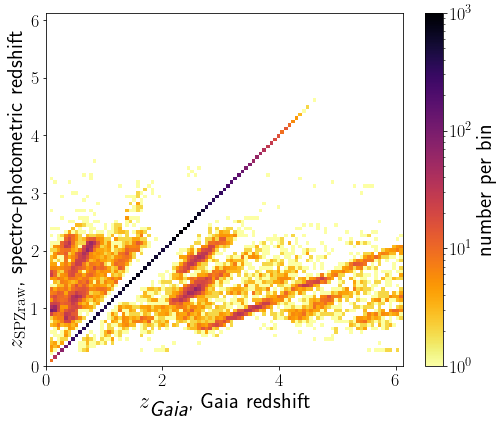

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzhi_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

try a smooth function

In [27]:
dz_min = dz_x
dz_max = dz_hi

frac_move = 1-(np.abs(dz_spzraw_gaia)-dz_min)/(dz_max-dz_min)
frac_move[frac_move<0] = 0
frac_move[frac_move>1] = 1
# print(np.min(frac_move), np.max(frac_move))
# print(np.min(frac_move*dz_spzraw_gaia), np.max(frac_move*dz_spzraw_gaia))
# #im = np.argmax((frac_move*dz_spzraw_gaia)[np.abs(dz_gaia_sdss)<0.07])
# im = np.where((np.abs(dz_spzraw_gaia) > 0.06) & (np.abs(dz_spzraw_gaia) < 0.07))[0][0]
# print(im)
# print(dz_spzraw_gaia[im], frac_move[im], (frac_move*dz_spzraw_gaia)[im])
z_spzsmooth_valid = z_spzraw_valid - frac_move*dz_spzraw_gaia*(1+z_gaia_valid)
dz_spzsmooth_sdss = (z_spzsmooth_valid - z_sdss_valid)/(1+z_sdss_valid)
# print(z_spzraw_valid[im], z_spzsmoothhi_valid[im], dz_spzsmoothhi_sdss[im])
# print(z_gaia_valid[im], z_sdss_valid[im], dz_gaia_sdss[im])

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

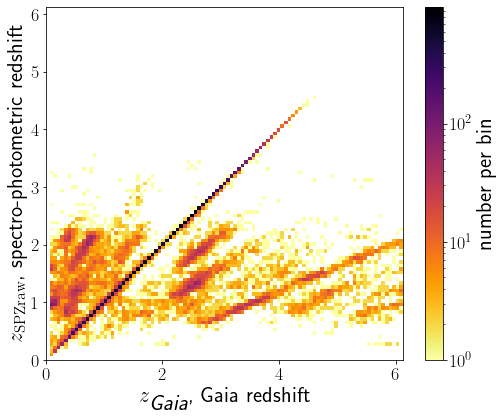

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzsmooth_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

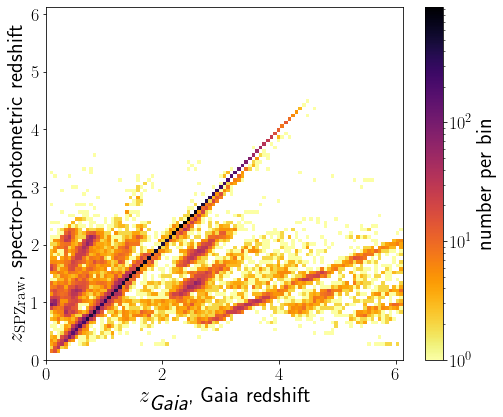

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzx_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

In [59]:
z_spzboost_valid = z_spzraw_valid.copy()
dz_sb = 0.1
i_useboost = np.abs(dz_boostraw_spzraw) > dz_sb
print("Number of SPZ's we'll switch out for Boost:", np.sum(i_useboost), "out of", len(i_useboost))
print(np.sum(i_useboost)/len(i_useboost))
z_spzboost_valid[i_useboost] = z_boostraw_valid[i_useboost]
dz_spzboost_sdss = (z_spzboost_valid - z_sdss_valid)/(1+z_sdss_valid)

Number of SPZ's we'll switch out for Boost: 3854 out of 36796
0.10473964561365366


Text(0, 0.5, '$z_\\mathrm{SPZBOOST}$, spectro-photometric redshift')

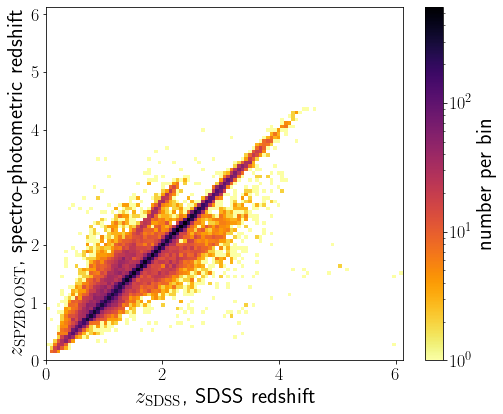

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_valid, z_spzboost_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{SPZBOOST}$, spectro-photometric redshift')

Text(0, 0.5, '$dz$')

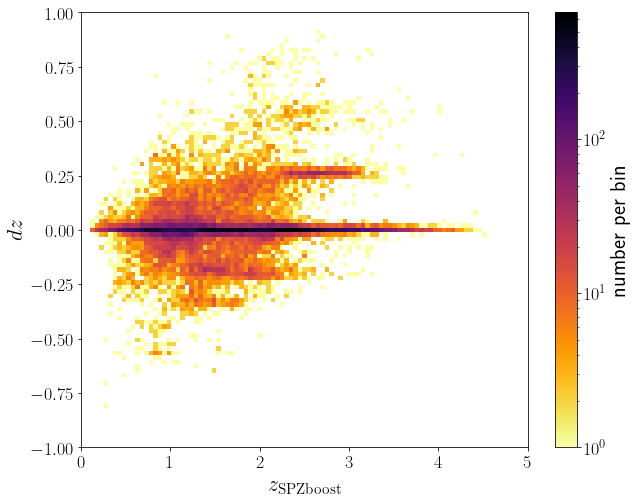

In [218]:
z_bins = np.linspace(0,5, 100)
dz_bins = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
h = ax.hist2d(z_spzsmooth_valid, dz_spzsmooth_sdss, bins=(z_bins, dz_bins), cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SPZboost}$')
plt.ylabel(r'$dz$')

In [30]:
G_max = 20.5
i_Gmax_valid = tab_spz_labeled['phot_g_mean_mag'][i_valid] < G_max

G_clean = 20.0
i_Gclean_valid = tab_spz_labeled['phot_g_mean_mag'][i_valid] < G_clean

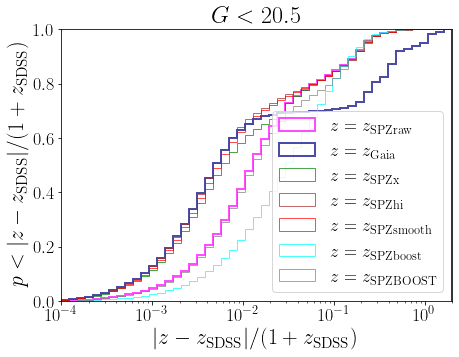

In [61]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_max}$', fontsize=24)
lw=1
alpha=0.7
plt.hist(abs(dz_spzraw_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='magenta', label=r'$z=z_\mathrm{SPZraw}$')
plt.hist(abs(dz_gaia_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.hist(abs(dz_spzx_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='green', label=r'$z=z_\mathrm{SPZx}$')
plt.hist(abs(dz_spzhi_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='brown', label=r'$z=z_\mathrm{SPZhi}$')
plt.hist(abs(dz_spzsmooth_sdss[i_Gmax_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='red', label=r'$z=z_\mathrm{SPZsmooth}$')
plt.hist(abs(dz_boostraw_sdss[i_Gmax_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='cyan', label=r'$z=z_\mathrm{SPZboost}$')
plt.hist(abs(dz_spzboost_sdss[i_Gmax_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{SPZBOOST}$')

plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

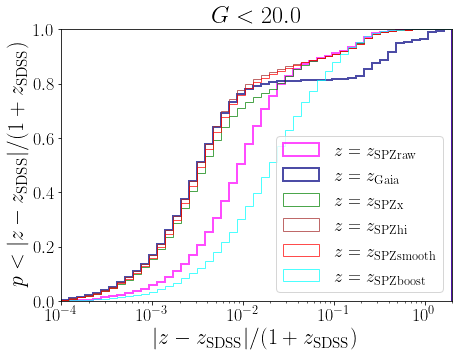

In [32]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_clean}$', fontsize=24)
lw=1
alpha=0.7
plt.hist(abs(dz_spzraw_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='magenta', label=r'$z=z_\mathrm{SPZraw}$')
plt.hist(abs(dz_gaia_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.hist(abs(dz_spzx_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='green', label=r'$z=z_\mathrm{SPZx}$')
plt.hist(abs(dz_spzhi_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='brown', label=r'$z=z_\mathrm{SPZhi}$')
plt.hist(abs(dz_spzsmooth_sdss[i_Gclean_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='red', label=r'$z=z_\mathrm{SPZsmooth}$')
plt.hist(abs(dz_boostraw_sdss[i_Gclean_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='cyan', label=r'$z=z_\mathrm{SPZboost}$')

plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

In [33]:
G_maxs = [20.0, 20.5, 20.6]

dz_threshs = [0.01, 0.1, 0.2]
for i in range(len(G_maxs)):
    print(f'G<{G_maxs[i]:.1f}')
    print()
    for iz, dz_thresh in enumerate(dz_threshs):

        i_insample = tab_spz_labeled['phot_g_mean_mag'][i_valid] < G_maxs[i]
        n_insample = np.sum(i_insample)
        
        f_outliers_spzraw = np.sum(np.abs(dz_spzraw_sdss[i_insample]) < dz_thresh) / n_insample
        f_outliers_gaia = np.sum(np.abs(dz_gaia_sdss[i_insample]) < dz_thresh) / n_insample
        f_outliers_spzsmooth = np.sum(np.abs(dz_spzsmooth_sdss[i_insample]) < dz_thresh) / n_insample
        f_outliers_boostraw = np.sum(np.abs(dz_boostraw_sdss[i_insample]) < dz_thresh) / n_insample
        
        print(f'Frac. of estimates with |dz|<{dz_thresh}:')
        print(f'SPZraw: {f_outliers_spzraw:.3f}')
        print(f'Gaia: {f_outliers_gaia:.3f}')
        print(f'SPZsmooth: {f_outliers_spzsmooth:.3f}')
        print(f'SPZboost: {f_outliers_boostraw:.3f}')
        print()

G<20.0

Frac. of estimates with |dz|<0.01:
SPZraw: 0.493
Gaia: 0.753
SPZsmooth: 0.754
SPZboost: 0.292

Frac. of estimates with |dz|<0.1:
SPZraw: 0.905
Gaia: 0.812
SPZsmooth: 0.905
SPZboost: 0.854

Frac. of estimates with |dz|<0.2:
SPZraw: 0.943
Gaia: 0.822
SPZsmooth: 0.942
SPZboost: 0.946

G<20.5

Frac. of estimates with |dz|<0.01:
SPZraw: 0.403
Gaia: 0.621
SPZsmooth: 0.620
SPZboost: 0.219

Frac. of estimates with |dz|<0.1:
SPZraw: 0.835
Gaia: 0.699
SPZsmooth: 0.834
SPZboost: 0.781

Frac. of estimates with |dz|<0.2:
SPZraw: 0.911
Gaia: 0.722
SPZsmooth: 0.909
SPZboost: 0.923

G<20.6

Frac. of estimates with |dz|<0.01:
SPZraw: 0.383
Gaia: 0.593
SPZsmooth: 0.591
SPZboost: 0.208

Frac. of estimates with |dz|<0.1:
SPZraw: 0.818
Gaia: 0.673
SPZsmooth: 0.816
SPZboost: 0.764

Frac. of estimates with |dz|<0.2:
SPZraw: 0.904
Gaia: 0.700
SPZsmooth: 0.901
SPZboost: 0.916



# Tuning K

In [143]:
Ks = np.arange(3, 50, 2)
#Ks = np.concatenate((Ks, [37, 41, 53, 73]))
#Ks = [23]
tabs_K = []
for K in Ks:
    redshift_estimator_name = 'kNN'
    save_tag_model = f'_K{K}'
    fn_spz_labeled_K = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
    tab_spz_labeled_K = utils.load_table(fn_spz_labeled_K)
    tabs_K.append(tab_spz_labeled_K)

In [144]:
dzs_spz_K = []
for tab_K in tabs_K:
    z_sdss_valid_K = tab_K['z_sdss'][i_valid]
    #z_spzraw_valid_K = tab_K['redshift_spz_raw'][i_valid]
    z_spz_valid_K = tab_K['redshift_spz'][i_valid]
    dz_spz_K = (z_spz_valid_K-z_sdss_valid_K)/(1+z_sdss_valid_K)
    dzs_spz_K.append(dz_spz_K)

0.01 13
0.05 19
0.1 27
0.2 37


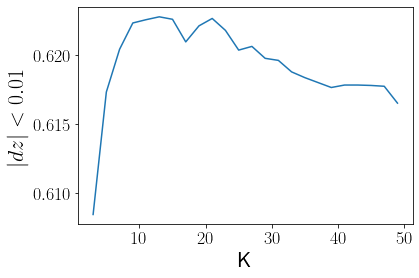

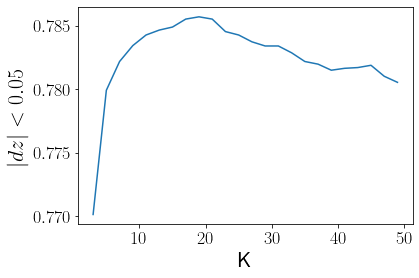

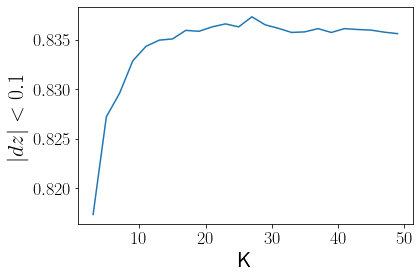

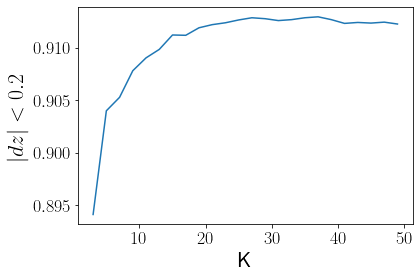

In [145]:
G_max = 20.5

dz_threshs = [0.01, 0.05, 0.1, 0.2]
#dz_threshs = [0.2

for iz, dz_thresh in enumerate(dz_threshs):
    
    plt.figure()
    fs_spz_K = []
    for dz_spz_K in dzs_spz_K:
        i_insample = tab_spz_labeled_K['phot_g_mean_mag'][i_valid] < G_max
        n_insample = np.sum(i_insample)

        f_spz_K = np.sum(np.abs(dz_spz_K[i_insample]) < dz_thresh) / n_insample
        fs_spz_K.append(f_spz_K)
        
    #plt.title('dz_\thresh')
    plt.plot(Ks, fs_spz_K)
    plt.xlabel('K')
    plt.ylabel(rf'$|dz| < {dz_thresh}$')
    print(dz_thresh, Ks[np.argmax(fs_spz_K)])

# proper motion error

### all

In [3]:
#tab_gall_wnec = utils.get_table_with_necessary(tab_gall)
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(f"Number of Gaia quasar candidates in clean sample: {len(tab_gclean)}")
print(tab_gclean.columns)

Number of Gaia quasar candidates in clean sample: 1414385
<TableColumns names=('source_id','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','pmra','pmra_error','pmdec','pmdec_error','parallax','parallax_error','ebv','A_v','pm','mag_w1_vg','mag_w2_vg','unwise_objid','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2')>


In [4]:
print(np.min(tab_gclean['pmra_error']), np.max(tab_gclean['pmra_error']))
print(np.min(tab_gclean['pmdec_error']), np.max(tab_gclean['pmdec_error']))
print(np.min(tab_gclean['pm']), np.max(tab_gclean['pm']))

0.014165468 2.9268804
0.01609325 2.901928
0.0005421096935336298 8.380152650573859


In [6]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz = utils.load_table(fn_spz)
print(f"N = {len(tab_spz)}")
print(tab_spz.columns)

N = 1414385
<TableColumns names=('source_id','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [7]:
tab_spz.keep_columns(['source_id', 'redshift_spz', 'redshift_spz_raw', 'redshift_spz_err'])
tab_gclean_spz = join(tab_gclean, tab_spz, keys='source_id')

In [9]:
redshift_estimator_name = 'hgboost'
save_tag_model = '_scale'
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz = utils.load_table(fn_spz)
tab_spz.rename_column('redshift_spz', 'redshift_boost')
tab_spz.rename_column('redshift_spz_raw', 'redshift_boost_raw')

In [10]:
tab_spz.keep_columns(['source_id', 'redshift_boost', 'redshift_boost_raw'])
tab_gclean_spz = join(tab_gclean_spz, tab_spz, keys='source_id')

In [11]:
z_name_arr = ['redshift_qsoc', 'redshift_spz', 'redshift_spz_raw', 'redshift_boost', 'redshift_boost_raw']

In [12]:
G_clean = 20.0
i_makesGcut = tab_gclean_spz['phot_g_mean_mag'] < G_clean

In [23]:
factor = 1000
pm_error = np.sqrt((factor*tab_gclean_spz['pmra_error'][i_makesGcut])**2 + 
                   (factor*tab_gclean_spz['pmdec_error'][i_makesGcut])**2)
z_bins = np.arange(0,6,0.2)
z_bins_avg = 0.5*(z_bins[:-1] + z_bins[1:])

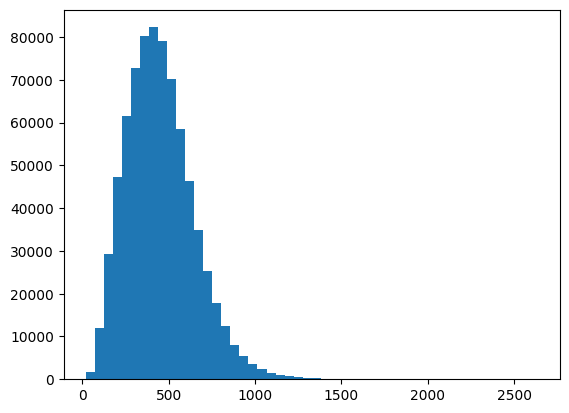

In [25]:
_ = plt.hist(pm_error, bins=50)

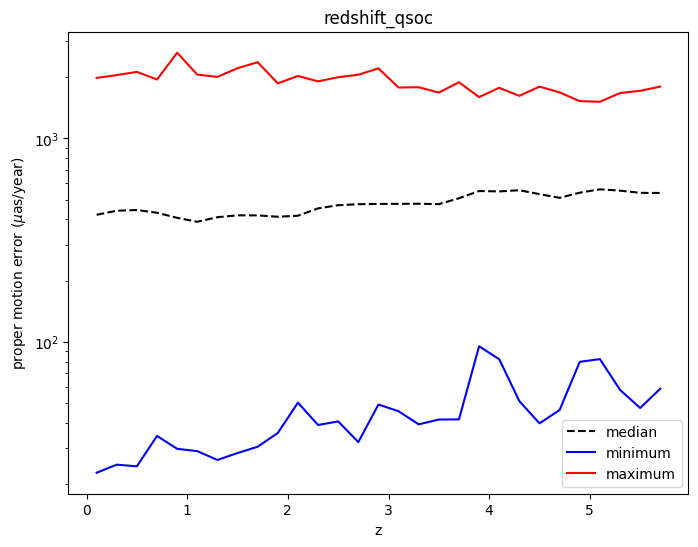

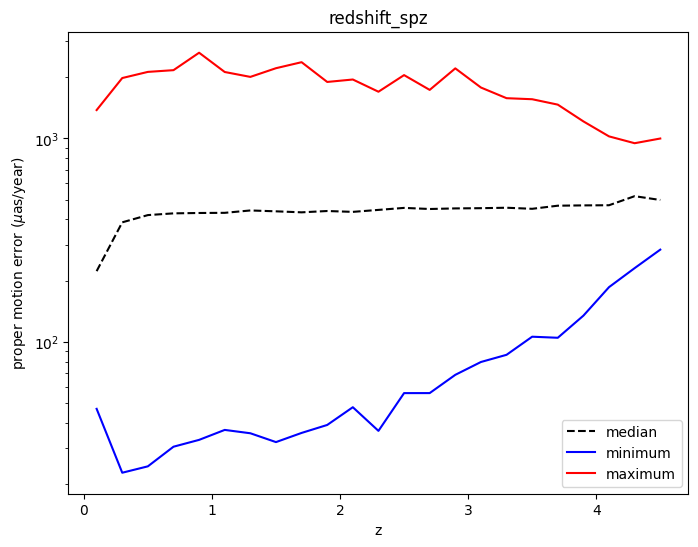

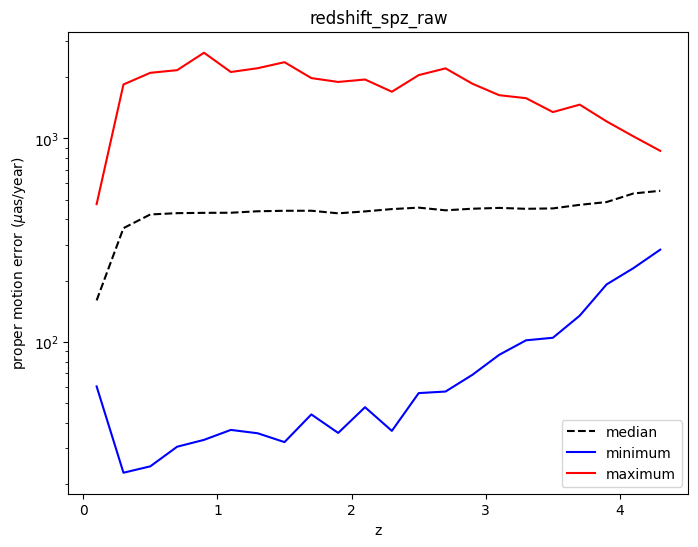

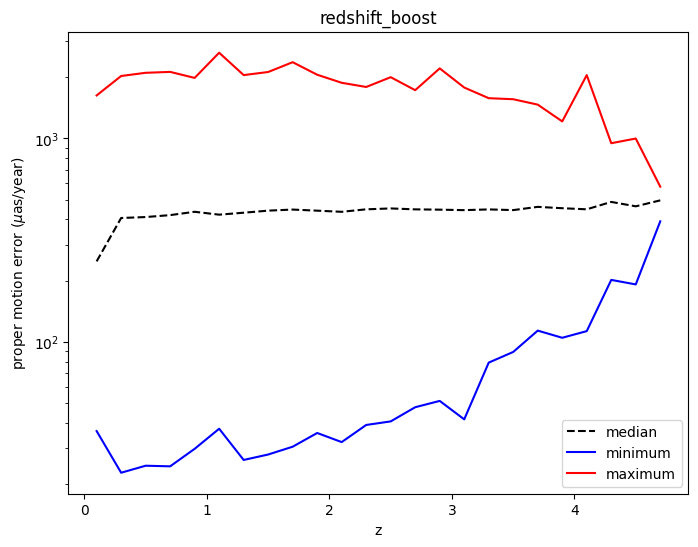

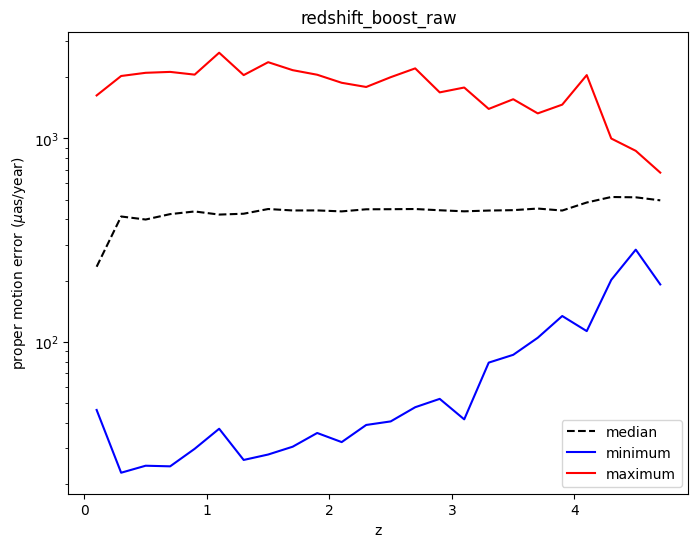

In [26]:
for z_name in z_name_arr:
    zs = tab_gclean_spz[z_name][i_makesGcut]

    pm_error_med = np.full(len(z_bins_avg), np.nan)
    pm_error_min = np.full(len(z_bins_avg), np.nan)
    pm_error_max = np.full(len(z_bins_avg), np.nan)
    for i in range(len(z_bins)-1):
        i_inbin = (zs >= z_bins[i]) & (zs < z_bins[i+1])
        if np.sum(i_inbin)==0:
            continue
        pm_error_med[i] = np.median(pm_error[i_inbin])
        pm_error_min[i] = np.min(pm_error[i_inbin])
        pm_error_max[i] = np.max(pm_error[i_inbin])
        
    plt.figure(figsize=(8,6))
    plt.title(z_name)
    plt.plot(z_bins_avg, pm_error_med, color='black', ls='--', label='median')
    plt.plot(z_bins_avg, pm_error_min, color='blue', label='minimum')
    plt.plot(z_bins_avg, pm_error_max, color='red', label='maximum')
    plt.yscale('log')
    plt.legend(loc='lower right')
    
    plt.xlabel('z')
    plt.ylabel(r'proper motion error ($\mu$as/year)')

### labeled

In [28]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 243206
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [29]:
tab_spz_labeled.keep_columns(['source_id', 'redshift_spz', 'redshift_spz_raw', 'z_sdss', 'redshift_spz_err'])
tab_gclean_spz_labeled = join(tab_gclean, tab_spz_labeled, keys='source_id')

In [31]:
redshift_estimator_name = 'hgboost'
save_tag_model = '_scale'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
tab_spz_labeled.rename_column('redshift_spz', 'redshift_boost')
tab_spz_labeled.rename_column('redshift_spz_raw', 'redshift_boost_raw')

In [32]:
tab_spz_labeled.keep_columns(['source_id', 'redshift_boost', 'redshift_boost_raw'])
tab_gclean_spz_labeled = join(tab_gclean_spz_labeled, tab_spz_labeled, keys='source_id')

In [33]:
z_name_arr = ['z_sdss', 'redshift_qsoc', 'redshift_spz', 'redshift_spz_raw', 'redshift_boost', 'redshift_boost_raw']

In [34]:
G_clean = 20.0
i_makesGcut = tab_gclean_spz_labeled['phot_g_mean_mag'] < G_clean

In [38]:
factor = 1000
pm_error = np.sqrt((factor*tab_gclean_spz_labeled['pmra_error'][i_makesGcut])**2 + 
                   (factor*tab_gclean_spz_labeled['pmdec_error'][i_makesGcut])**2)
z_bins = np.arange(0,6,0.2)
z_bins_avg = 0.5*(z_bins[:-1] + z_bins[1:])

In [39]:
len(tab_gclean_spz), np.sum(i_makesGcut)

(1414385, 124719)

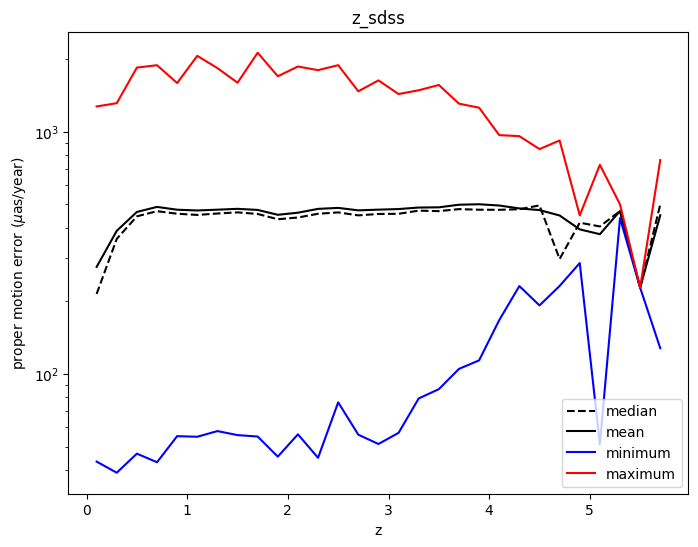

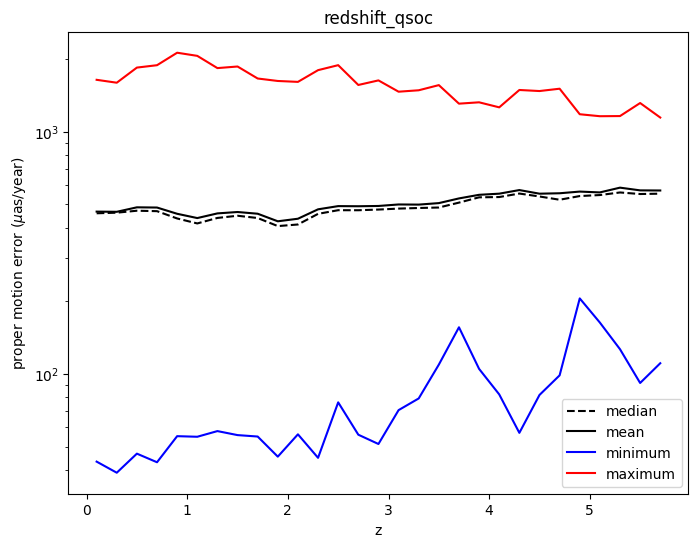

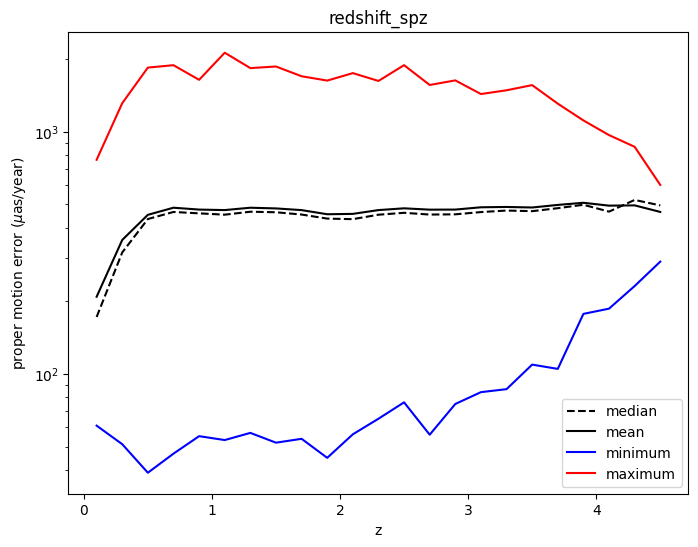

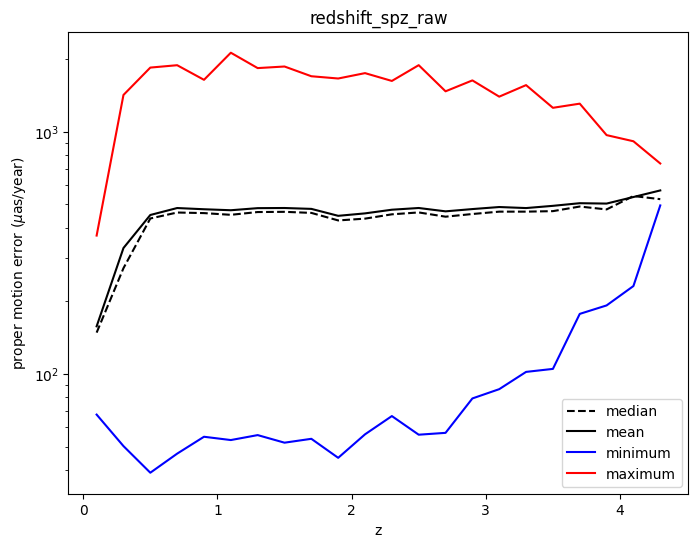

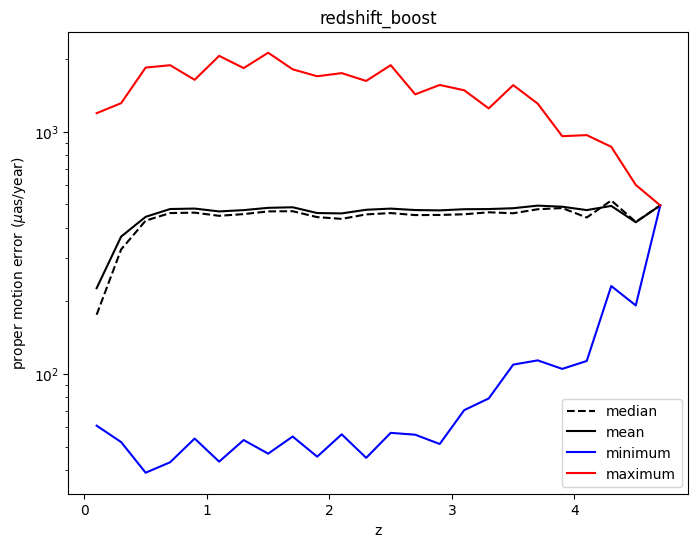

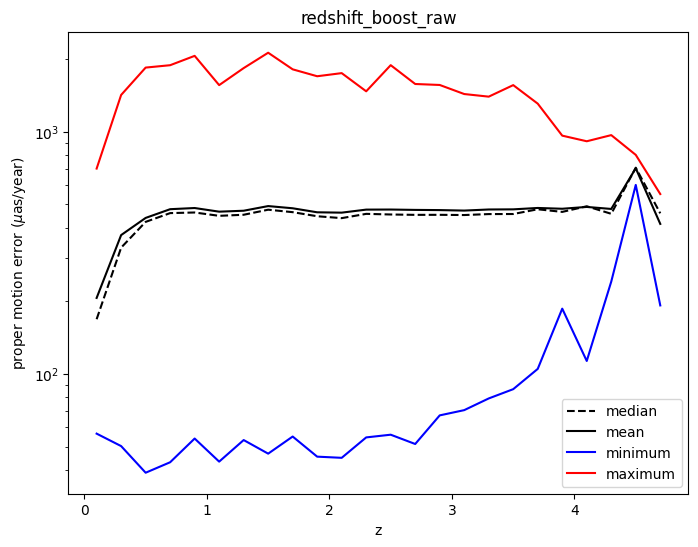

In [42]:
for z_name in z_name_arr:
    zs = tab_gclean_spz_labeled[z_name][i_makesGcut]

    pm_error_med = np.full(len(z_bins_avg), np.nan)
    pm_error_mean = np.full(len(z_bins_avg), np.nan)
    pm_error_min = np.full(len(z_bins_avg), np.nan)
    pm_error_max = np.full(len(z_bins_avg), np.nan)
    for i in range(len(z_bins)-1):
        i_inbin = (zs >= z_bins[i]) & (zs < z_bins[i+1])
        if np.sum(i_inbin)==0:
            continue
        pm_error_med[i] = np.median(pm_error[i_inbin])
        pm_error_mean[i] = np.mean(pm_error[i_inbin])
        pm_error_min[i] = np.min(pm_error[i_inbin])
        pm_error_max[i] = np.max(pm_error[i_inbin])
        
    plt.figure(figsize=(8,6))
    plt.title(z_name)
    plt.plot(z_bins_avg, pm_error_med, color='black', ls='--', label='median')
    plt.plot(z_bins_avg, pm_error_mean, color='black', ls='-', label='mean')
    plt.plot(z_bins_avg, pm_error_min, color='blue', label='minimum')
    plt.plot(z_bins_avg, pm_error_max, color='red', label='maximum')
    plt.yscale('log')
    plt.legend(loc='lower right')
    
    plt.xlabel('z')
    plt.ylabel(r'proper motion error ($\mu$as/year)')

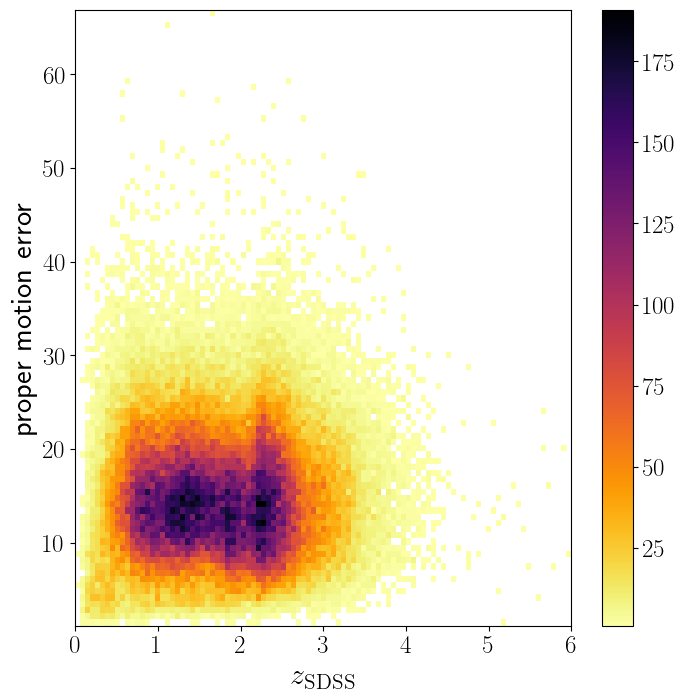

In [37]:

z_bins = np.linspace(0, 6, 100)
pm_error_bins = np.linspace(np.min(pm_error), np.max(pm_error), 100)

plt.figure(figsize=(8,8))
plt.hist2d(tab_gclean_spz_labeled['z_sdss'][i_makesGcut], pm_error, bins=(z_bins, pm_error_bins), 
           cmin=1, cmap='inferno_r')
plt.xlabel(r"$z_\mathrm{SDSS}$")
plt.ylabel('proper motion error')
plt.colorbar()

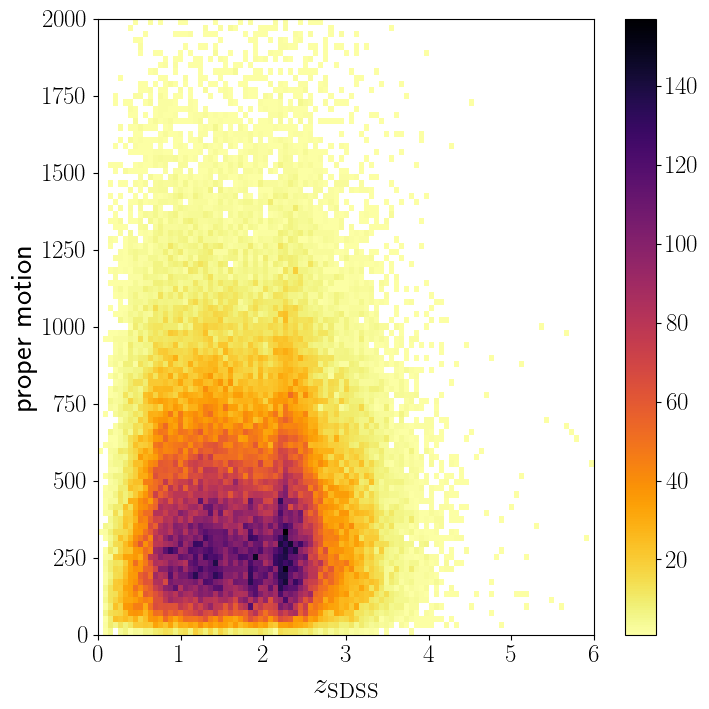

In [38]:

z_bins = np.linspace(0, 6, 100)
pm = factor*tab_gclean_spz_labeled['pm'][i_makesGcut]
pm_bins = np.linspace(0, 2000, 100)

plt.figure(figsize=(8,8))
plt.hist2d(tab_gclean_spz_labeled['z_sdss'][i_makesGcut], pm, bins=(z_bins, pm_bins), 
           cmin=1, cmap='inferno_r')
plt.xlabel(r"$z_\mathrm{SDSS}$")
plt.ylabel('proper motion')
plt.colorbar()

# SNR

In [39]:
tab_gclean_spz.columns

<TableColumns names=('source_id','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','pmra','pmra_error','pmdec','pmdec_error','parallax','parallax_error','ebv','A_v','pm','rand_ints','mag_w1_vg','mag_w2_vg','unwise_objid','g_rp','bp_g','bp_rp','g_w1','w1_w2','redshift_spz_raw','redshift_spz_err','redshift_spz','redshift_boost_raw','redshift_boost')>

In [40]:
snr = tab_gclean_spz['redshift_spz']/tab_gclean_spz['redshift_spz_err']

Text(0, 0.5, '$\\Delta z$')

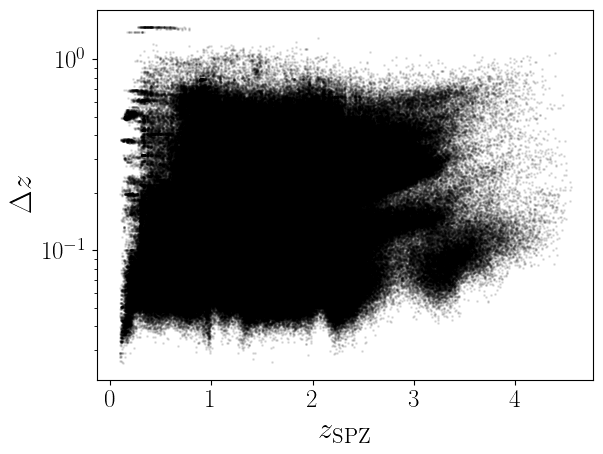

In [63]:
plt.scatter(tab_gclean_spz['redshift_spz'], tab_gclean_spz['redshift_spz_err'], color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'$\Delta z$')

Text(0, 0.5, 'SNR = $z/\\Delta z$')

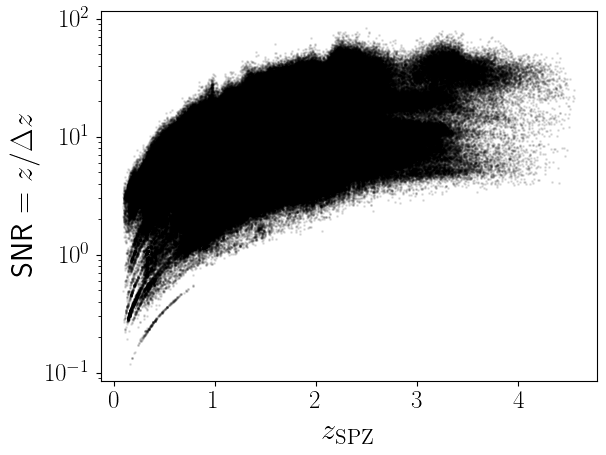

In [64]:
plt.scatter(tab_gclean_spz['redshift_spz'], snr, color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'SNR = $z/\Delta z$')

Text(0, 0.5, 'SNR = $z/\\Delta z$')

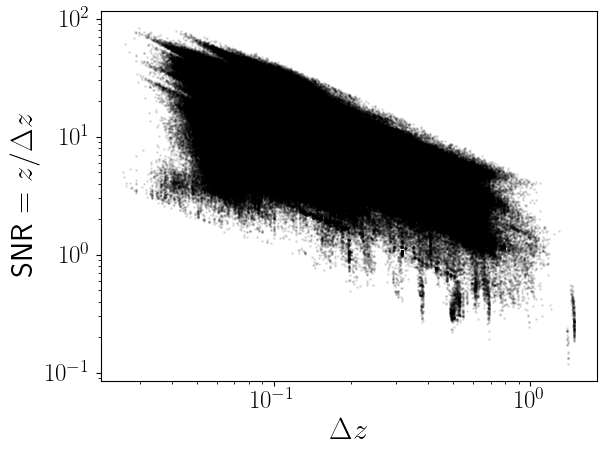

In [65]:
plt.scatter(tab_gclean_spz['redshift_spz_err'], snr, color='k', s=1, alpha=0.1)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\Delta z$')
plt.ylabel(r'SNR = $z/\Delta z$')

In [67]:
print(np.sum(tab_gclean_spz['redshift_spz_err']>1))
print(np.sum(snr<0.8))

568
3801


In [53]:
print(np.min(tab_gclean_spz_labeled['z_sdss']))
print(np.sum(tab_gclean_spz_labeled['z_sdss']<0.1))
print(np.sum(tab_gclean_spz_labeled['z_sdss']<1))

0.058
28
46572


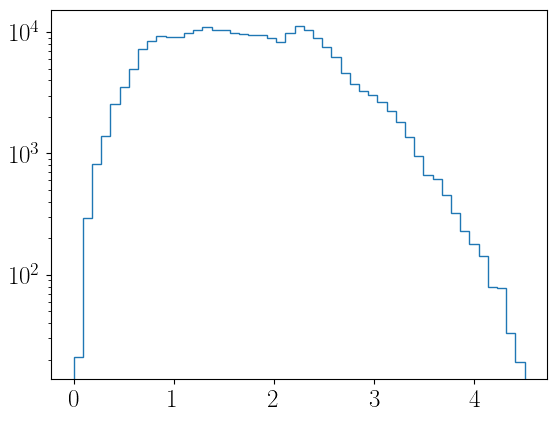

In [49]:
z_bins = np.linspace(0, 4.5, 50)
plt.hist(tab_gclean_spz_labeled['z_sdss'], bins=z_bins, histtype='step')
plt.yscale('log')

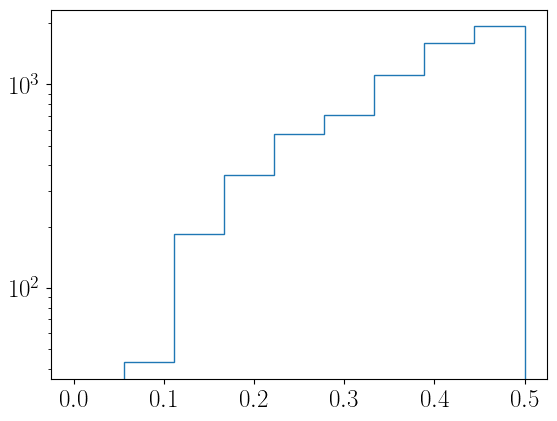

In [54]:
z_bins = np.linspace(0, 0.5, 10)
plt.hist(tab_gclean_spz_labeled['z_sdss'], bins=z_bins, histtype='step')
plt.yscale('log')

In [70]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [71]:
snr = tab_spz_labeled['redshift_spz']/tab_spz_labeled['redshift_spz_err']

Text(0, 0.5, 'SNR = $z/\\Delta z$')

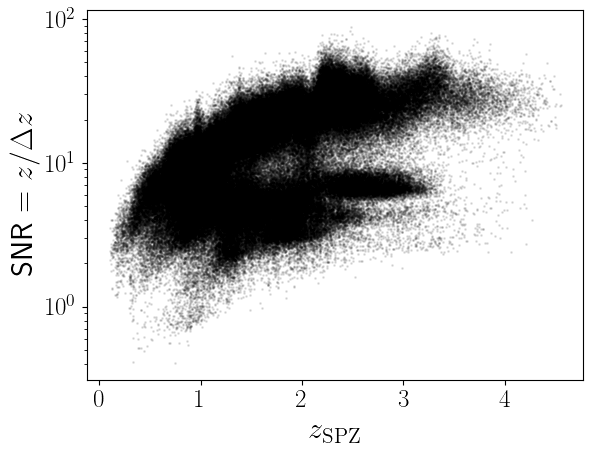

In [72]:
plt.scatter(tab_spz_labeled['redshift_spz'], snr, color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'SNR = $z/\Delta z$')

In [73]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_2std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [74]:
snr = tab_spz_labeled['redshift_spz']/tab_spz_labeled['redshift_spz_err']

Text(0, 0.5, 'SNR = $z/\\Delta z$')

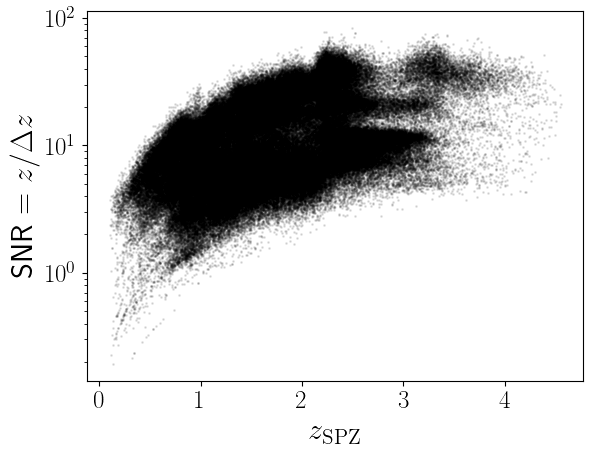

In [75]:
plt.scatter(tab_spz_labeled['redshift_spz'], snr, color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'SNR = $z/\Delta z$')

### all

In [128]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz = utils.load_table(fn_spz)
print(f"N = {len(tab_spz)}")
print(tab_spz.columns)

N = 1442077
<TableColumns names=('source_id','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [129]:
snr = tab_spz['redshift_spz']/tab_spz['redshift_spz_err']

Text(0, 0.5, 'SNR = $z/\\Delta z$')

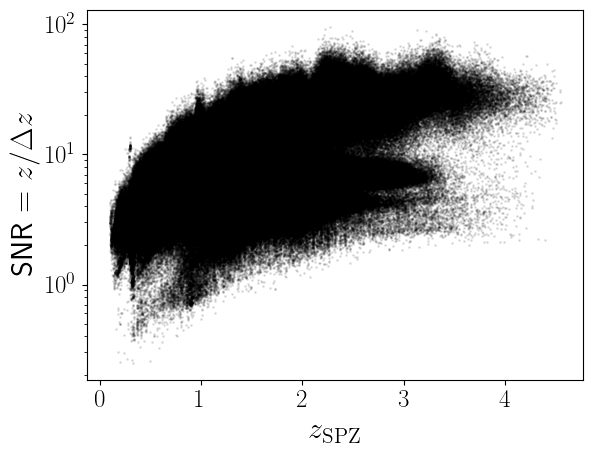

In [130]:
plt.scatter(tab_spz['redshift_spz'], snr, color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'SNR = $z/\Delta z$')

Text(0, 0.5, '$\\Delta z$')

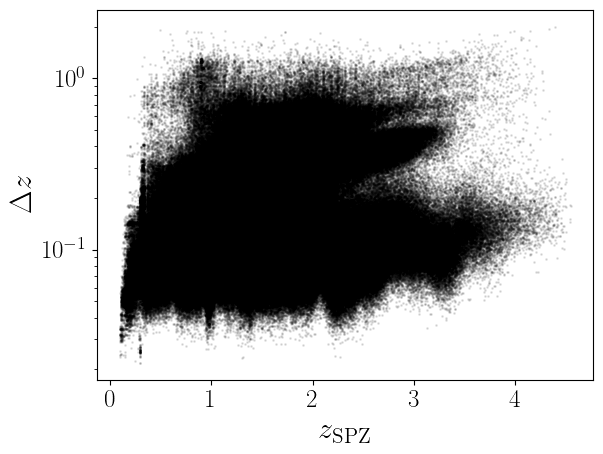

In [131]:
plt.scatter(tab_spz['redshift_spz'], tab_spz['redshift_spz_err'], color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'$\Delta z$')

In [132]:
np.sum(snr<1), np.sum(snr<2)

(2841, 21231)

In [133]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_2std'
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz = utils.load_table(fn_spz)
print(f"N = {len(tab_spz)}")
print(tab_spz.columns)

N = 1442077
<TableColumns names=('source_id','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [134]:
snr = tab_spz['redshift_spz']/tab_spz['redshift_spz_err']

Text(0, 0.5, 'SNR = $z/\\Delta z$')

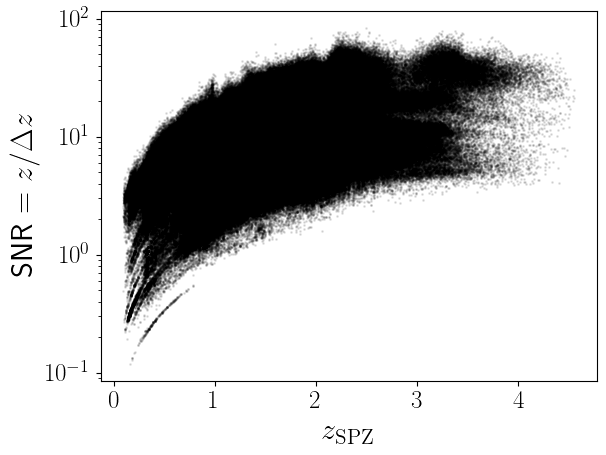

In [135]:
plt.scatter(tab_spz['redshift_spz'], snr, color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'SNR = $z/\Delta z$')

Text(0, 0.5, '$\\Delta z$')

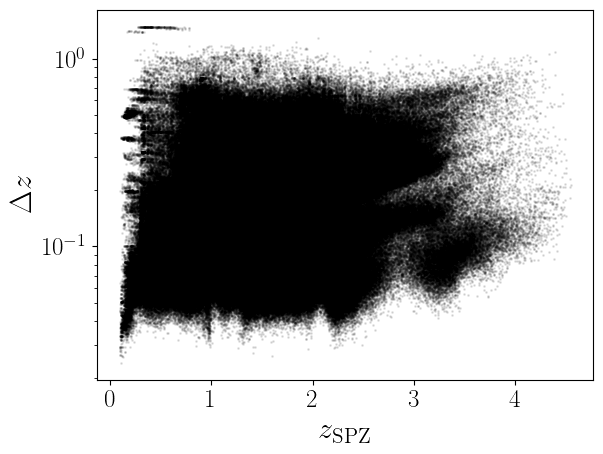

In [136]:
plt.scatter(tab_spz['redshift_spz'], tab_spz['redshift_spz_err'], color='k', s=1, alpha=0.1)
plt.yscale('log')

plt.xlabel(r'$z_\mathrm{SPZ}$')
plt.ylabel(r'$\Delta z$')

In [137]:
np.sum(snr<1), np.sum(snr<2)

(6107, 31576)